In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
import dataframe_image as dfi
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
encoder = OneHotEncoder(sparse_output=False)
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import Imputeed Ames Data
Ames = pd.read_csv('Ames_HousePrice_Imputed.csv')

#Update with new Ames Data
Ames_Columns_Numeric = Ames[[
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath',
    'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr',
    'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'MoSold',
    'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'TotRmsAbvGrd', 'WoodDeckSF',
    'YearBuilt', 'YearRemodAdd', 'YrSold'
]]
Ames_Columns_Ordinal = Ames[[ 
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
    'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional',
    'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual',
    'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'PavedDrive',
    'PoolQC', 'Utilities'
]]
Ames_Columns_Nominal = Ames[[ 
    'Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
    'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating',
    'HouseStyle', 'LandContour', 'LotConfig', 'MasVnrType', 'MiscFeature',
    'MSSubClass', 'MSZoning', 'Neighborhood', 'RoofMatl', 'RoofStyle',
    'SaleCondition', 'SaleType', 'Street'
]].astype(str)

#Combination Table of Numeric & Ordinal Columns
Ames_Columns_Numeric_Ordinal = Ames[
    list(Ames_Columns_Numeric.columns) + list(Ames_Columns_Ordinal.columns)
]
#Combination Table of Nominal & Ordinal Columns
Ames_Columns_Nominal_Ordinal = Ames[
    list(Ames_Columns_Nominal.columns) + list(Ames_Columns_Ordinal.columns)
]

In [3]:
encoder = OneHotEncoder(sparse_output=False)
encoder_nominal = OneHotEncoder(sparse_output=False)
encoder_ordinal = OneHotEncoder(sparse_output=False)
Nominal_cols = Ames_Columns_Nominal.columns
Ordinal_cols = Ames_Columns_Ordinal.columns
Numeric_cols = Ames_Columns_Numeric.columns

# --- One-Hot Encode Nominal ---
Ames_Optimal_Nominal_One_Hot = encoder_nominal.fit_transform(Ames[Nominal_cols])
Ames_Optimal_Nominal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Nominal_One_Hot,
    columns=encoder_nominal.get_feature_names_out(Nominal_cols),
    index=Ames.index
)
#DO NOT One-Hot Encode Ordinal (for now)
Ames_Optimal_Ordinal_One_Hot = Ames_Columns_Ordinal #encoder_ordinal.fit_transform(Ames[Ordinal_cols])
Ames_Optimal_Ordinal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Ordinal_One_Hot,
    #columns=encoder_ordinal.get_feature_names_out(Ordinal_cols),
    index=Ames.index
)
#Merge Nominal & Ordinal Encodings
Ames_Optimal_Categorical_One_Hot = pd.merge(
    Ames_Optimal_Nominal_One_Hot_df,
    Ames_Optimal_Ordinal_One_Hot_df,
    left_index=True,
    right_index=True,
    how='left'
)
#Merge with Numeric Features
Ames_MLR_Optimal_Columns = pd.merge(
    Ames[Numeric_cols],
    Ames_Optimal_Categorical_One_Hot,
    left_index=True,
    right_index=True,
    how='left'
)

In [4]:
Y = Ames['SalePrice']
X = Ames_MLR_Optimal_Columns

Best parameters: {'criterion': 'squared_error', 'max_depth': 9}
Best CV accuracy: 0.7916


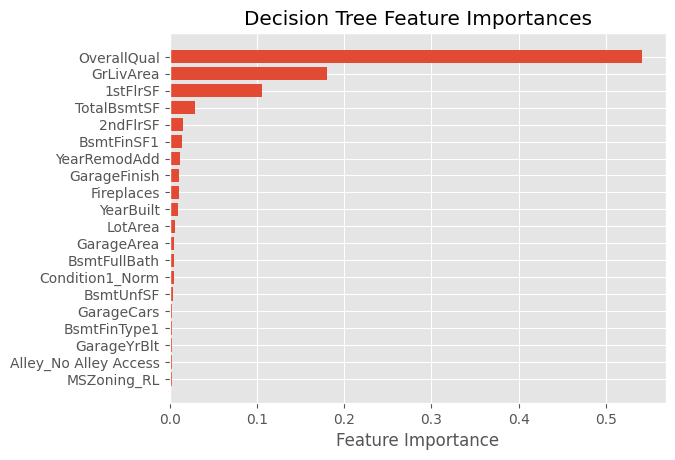

OverallQual: 0.5413
GrLivArea: 0.1799
1stFlrSF: 0.1064
TotalBsmtSF: 0.0287
2ndFlrSF: 0.0158
BsmtFinSF1: 0.0147
YearRemodAdd: 0.0118
GarageFinish: 0.0109
Fireplaces: 0.0108
YearBuilt: 0.0095
LotArea: 0.0066
GarageArea: 0.0051
BsmtFullBath: 0.0047
Condition1_Norm: 0.0046
BsmtUnfSF: 0.0036
GarageCars: 0.0033
BsmtFinType1: 0.0031
GarageYrBlt: 0.0031
Alley_No Alley Access: 0.0026
MSZoning_RL: 0.0024
MSZoning_RM: 0.0023
FireplaceQu: 0.0022
BsmtQual: 0.0021
BedroomAbvGr: 0.0018
OpenPorchSF: 0.0018
SaleType_WD : 0.0016
BsmtExposure: 0.0016
GarageCond: 0.0016
MasVnrArea: 0.0013
Neighborhood_ClearCr: 0.0012
HalfBath: 0.0010
KitchenQual: 0.0010
SaleCondition_Family: 0.0009
LotShape: 0.0009
MoSold: 0.0009
LandSlope: 0.0008
LotFrontage: 0.0007
OverallCond: 0.0006
Neighborhood_Timber: 0.0006
Neighborhood_Gilbert: 0.0006
Neighborhood_NAmes: 0.0005
LandContour_Lvl: 0.0005
Condition1_Feedr: 0.0004
Condition1_PosN: 0.0004
ExterCond: 0.0004
CentralAir_Y: 0.0004
Functional: 0.0004
WoodDeckSF: 0.0003
YrSol

In [6]:
#Decision Tree Regressor
'''
tree_model = DecisionTreeRegressor(random_state=2)

#Grid Search
grid_para_tree = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': range(1, 31)
}
grid_search_tree = GridSearchCV(
    estimator=tree_model,
    param_grid=grid_para_tree,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search_tree.fit(X, Y)

print('Best parameters:', grid_search_tree.best_params_)
print('Best CV accuracy: %.4f' % grid_search_tree.best_score_)
best_tree = grid_search_tree.best_estimator_
importances = best_tree.feature_importances_

#Feature Name-Importance Pairs
feature_names = X.columns
feature_importance = list(zip(feature_names, importances))
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

#Plot Top 20 Feature Importances
top_features = feature_importance_sorted[:20]
names, values = zip(*top_features)
plt.barh(names, values)
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importances')
plt.show()

#Print All Importances
for name, importance in feature_importance_sorted:
    print(f"{name}: {importance:.4f}")
'''

In [14]:
bag_basic = cross_val_score(BaggingRegressor(random_state=2), X, Y, cv=5, scoring='r2')
float(bag_basic.mean())

0.881530875341394

In [15]:
base_tree = DecisionTreeRegressor(random_state=2)
bagging_model = BaggingRegressor(estimator=base_tree, random_state=2, n_jobs=-1)

In [24]:
#Initial Bagging RandomizedSearchCV for faster estimates
'''
param_dist = {
    'estimator__criterion': ['squared_error', 'absolute_error'],
    'estimator__max_depth': [21, 22, 23],
    'n_estimators': [75, 76, 77]
}
random_search = RandomizedSearchCV(
    bagging_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search.fit(X, Y)
print('Best parameters:', random_search.best_params_)
print(f'Best CV Score: {random_search.best_score_:.4f}')
'''

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'n_estimators': 76, 'estimator__max_depth': 22, 'estimator__criterion': 'squared_error'}
Best CV Score: 0.8960


In [31]:
#Final Bagging Grid Search
'''
grid_params_bagging = {
    'estimator__criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'estimator__max_depth': [21, 22, 23],
    'n_estimators': [70, 71, 72]
}
grid_search_bagging = GridSearchCV(
    estimator=bagging_model,
    param_grid=grid_params_bagging,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_bagging.fit(X, Y)

print('Best parameters:', grid_search_bagging.best_params_)
print(f'Best CV R²: {grid_search_bagging.best_score_:.4f}')
'''

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 22, 'n_estimators': 71}
Best CV R²: 0.8959


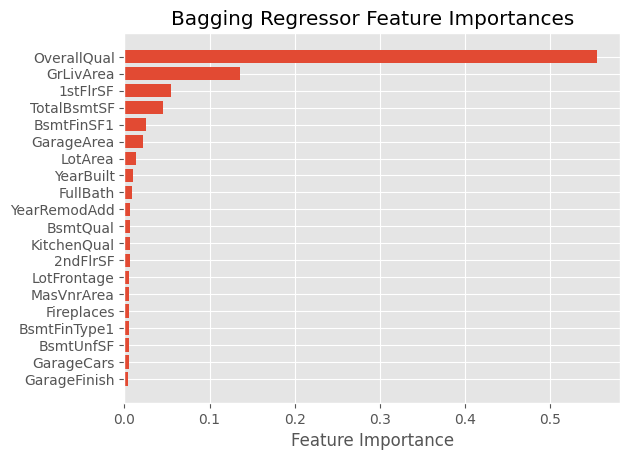

OverallQual: 0.5551
GrLivArea: 0.1361
1stFlrSF: 0.0546
TotalBsmtSF: 0.0448
BsmtFinSF1: 0.0252
GarageArea: 0.0216
LotArea: 0.0138
YearBuilt: 0.0103
FullBath: 0.0093
YearRemodAdd: 0.0070
BsmtQual: 0.0069
KitchenQual: 0.0063
2ndFlrSF: 0.0061
LotFrontage: 0.0058
MasVnrArea: 0.0057
Fireplaces: 0.0055
BsmtFinType1: 0.0050
BsmtUnfSF: 0.0048
GarageCars: 0.0048
GarageFinish: 0.0042
ExterQual: 0.0039
OpenPorchSF: 0.0038
WoodDeckSF: 0.0035
OverallCond: 0.0032
MoSold: 0.0031
GarageYrBlt: 0.0030
FireplaceQu: 0.0027
ScreenPorch: 0.0026
MSZoning_RM: 0.0025
BsmtFullBath: 0.0017
BsmtExposure: 0.0016
HeatingQC: 0.0013
YrSold: 0.0013
TotRmsAbvGrd: 0.0013
BedroomAbvGr: 0.0010
LotShape: 0.0009
Neighborhood_Crawfor: 0.0009
CentralAir_Y: 0.0008
Neighborhood_Edwards: 0.0008
HalfBath: 0.0007
GarageType_Detchd: 0.0007
SaleCondition_Family: 0.0007
MSZoning_RL: 0.0007
CentralAir_N: 0.0006
Functional: 0.0006
Exterior2nd_HdBoard: 0.0006
BsmtCond: 0.0006
SaleType_WD : 0.0006
EnclosedPorch: 0.0005
Foundation_PConc: 0

In [32]:
#Bagging Feature Importances (bagging averages)
'''
best_bagging = grid_search_bagging.best_estimator_
importances = np.mean(
    [tree.feature_importances_ for tree in best_bagging.estimators_],
    axis=0
)
#Pair with Feature Names
feature_importance = list(zip(X.columns, importances))
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

#Plot Top 20 Feature Importances
top_features = feature_importance_sorted[:20]
names, values = zip(*top_features)
plt.barh(names, values)
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Bagging Regressor Feature Importances')
plt.show()

#Print all Importances
for name, importance in feature_importance_sorted:
    print(f"{name}: {importance:.4f}")
'''

In [26]:
#Base Random Forest Model 
rf_model = RandomForestRegressor(random_state=2, n_jobs=-1)
rf_model.fit(X, Y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
cross_val_score(rf_model, X, Y).mean()

np.float64(0.8951755258558339)

In [10]:
#Initial Random Forest RandomizedSearchCV for faster estimates
'''
param_dist_rf = {
    'criterion': ['friedman_mse'],
    'max_depth': range(21, 27),
    'n_estimators': range(156, 224),
    'max_features': ['sqrt']
}
random_search_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist_rf,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_rf.fit(X, Y)
print('Best parameters:', random_search_rf.best_params_)
print(f'Best CV R²: {random_search_rf.best_score_:.4f}')
'''

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 192, 'max_features': 'sqrt', 'max_depth': 24, 'criterion': 'friedman_mse'}
Best CV R²: 0.8966


In [11]:
#Final Random Forest Grid Search
'''
grid_params_rf = {
    'criterion': ['friedman_mse'],
    'max_depth': range(21, 28),
    'n_estimators': range(180, 205),
    'max_features': ['sqrt']
}
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=grid_params_rf,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X, Y)
print('Best parameters:', grid_search_rf.best_params_)
print(f'Best CV R²: {grid_search_rf.best_score_:.4f}')
'''

Fitting 5 folds for each of 175 candidates, totalling 875 fits
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 24, 'max_features': 'sqrt', 'n_estimators': 192}
Best CV R²: 0.8966


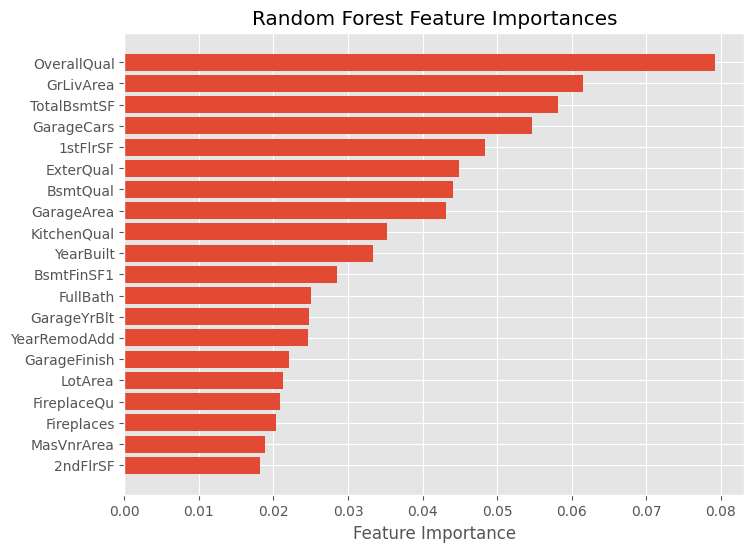

OverallQual: 0.0792
GrLivArea: 0.0616
TotalBsmtSF: 0.0582
GarageCars: 0.0548
1stFlrSF: 0.0484
ExterQual: 0.0449
BsmtQual: 0.0441
GarageArea: 0.0432
KitchenQual: 0.0353
YearBuilt: 0.0333
BsmtFinSF1: 0.0285
FullBath: 0.0250
GarageYrBlt: 0.0248
YearRemodAdd: 0.0247
GarageFinish: 0.0221
LotArea: 0.0213
FireplaceQu: 0.0208
Fireplaces: 0.0204
MasVnrArea: 0.0188
2ndFlrSF: 0.0182
TotRmsAbvGrd: 0.0151
LotFrontage: 0.0144
Foundation_PConc: 0.0142
MSSubClass_60: 0.0112
BsmtFinType1: 0.0110
BsmtExposure: 0.0090
OpenPorchSF: 0.0089
MasVnrType_No Veneer: 0.0079
WoodDeckSF: 0.0075
HeatingQC: 0.0074
BsmtUnfSF: 0.0068
BedroomAbvGr: 0.0059
RoofStyle_Hip: 0.0050
GarageType_Attchd: 0.0050
BsmtFullBath: 0.0049
GarageType_Detchd: 0.0046
Neighborhood_NridgHt: 0.0046
Foundation_CBlock: 0.0044
OverallCond: 0.0043
HalfBath: 0.0041
RoofStyle_Gable: 0.0039
Exterior2nd_VinylSd: 0.0039
MoSold: 0.0038
Neighborhood_NoRidge: 0.0034
Exterior1st_VinylSd: 0.0032
ScreenPorch: 0.0031
LotShape: 0.0029
HouseStyle_1Story: 0.0

In [12]:
#Random Forest Feature Importances 
best_rf = grid_search_rf.best_estimator_
importances = best_rf.feature_importances_

#Pair with Feature Names
feature_importance = list(zip(X.columns, importances))
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

#Plot Top 20 Feature Importances
top_features = feature_importance_sorted[:20]
names, values = zip(*top_features)

plt.figure(figsize=(8, 6))
plt.barh(names, values)
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()

#Print all Feature Importances
for name, importance in feature_importance_sorted:
    print(f'{name}: {importance:.4f}')

In [14]:
#Gradient Boosting
gbm = GradientBoostingRegressor(random_state=2, verbose=1)
gbm.fit(X, Y)

      Iter       Train Loss   Remaining Time 
         1  4844443779.7734            3.21s
         2  4186475306.2411            2.81s
         3  3647244417.1483            2.67s
         4  3195085263.6057            2.59s
         5  2806968198.0603            2.55s
         6  2488502032.9832            2.59s
         7  2211406942.9509            2.65s
         8  1979081595.9975            2.50s
         9  1769485791.0540            2.35s
        10  1586705403.9391            2.30s
        20   709796683.5749            1.80s
        30   451529330.0990            1.56s
        40   346356827.7832            1.36s
        50   295046008.7429            1.13s
        60   262640066.6024            0.87s
        70   239821746.4581            0.63s
        80   221500863.6241            0.41s
        90   207386436.6705            0.20s
       100   196483824.0830            0.00s


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [30]:
gbm.score(X, Y)
cross_val_score(gbm, X, Y).mean()

      Iter       Train Loss   Remaining Time 
         1  4541205303.3751            2.62s
         2  3925329347.9286            2.42s
         3  3407690380.5198            2.20s
         4  2973081126.3941            2.24s
         5  2605556518.4339            2.26s
         6  2303283596.7830            2.25s
         7  2044582357.1434            2.22s
         8  1813887944.0161            2.22s
         9  1612351749.8694            2.20s
        10  1453410013.0922            2.23s
        20   612024530.5015            1.99s
        30   374431730.8410            1.65s
        40   285678745.0720            1.41s
        50   242743961.9985            1.19s
        60   214289684.4926            0.95s
        70   195273222.5784            0.71s
        80   180626758.4808            0.47s
        90   168606209.2128            0.23s
       100   157237445.1394            0.00s
      Iter       Train Loss   Remaining Time 
         1  4572328385.6264            2.26s
        

np.float64(0.9053026587496849)

In [18]:
hgbm = HistGradientBoostingRegressor(random_state=2, verbose=1)
hgbm.fit(X, Y)

Binning 0.005 GB of training data: 0.065 s
Fitting gradient boosted rounds:
Fit 100 trees in 5.835 s, (3100 total leaves)
Time spent computing histograms: 1.240s
Time spent finding best splits:  0.160s
Time spent applying splits:      0.141s
Time spent predicting:           0.005s


,loss,'squared_error'
,quantile,None
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


In [31]:
hgbm.score(X, Y)
cross_val_score(hgbm, X, Y).mean()

Binning 0.004 GB of training data: 0.058 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.690 s, (3100 total leaves)
Time spent computing histograms: 0.952s
Time spent finding best splits:  0.114s
Time spent applying splits:      0.088s
Time spent predicting:           0.006s
Binning 0.004 GB of training data: 0.068 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.618 s, (3100 total leaves)
Time spent computing histograms: 0.914s
Time spent finding best splits:  0.106s
Time spent applying splits:      0.081s
Time spent predicting:           0.005s
Binning 0.004 GB of training data: 0.068 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.634 s, (3100 total leaves)
Time spent computing histograms: 0.924s
Time spent finding best splits:  0.107s
Time spent applying splits:      0.083s
Time spent predicting:           0.005s
Binning 0.004 GB of training data: 0.067 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.649 s, (3100 total leaves)
Time spent computing histograms:

np.float64(0.9121093445438377)

In [32]:
#Initial Gradient Boosting RandomizedSearchCV for faster estimates
rand_param_hgbm = {
    'learning_rate': [0.06375, 0.0651575, 0.066565],
    'max_leaf_nodes': [9, 10, 11],
    'max_iter': [212, 219, 224],
    'min_samples_leaf': [15],
    #'l2_regularization': [0.0, 0.1, 0.5, 1.0],
}
random_search_hgb = RandomizedSearchCV(
    estimator=hgbm,
    param_distributions=rand_param_hgbm,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_hgb.fit(X, Y)
print('Best parameters:', random_search_hgb.best_params_)
print(f'Best CV R²: {random_search_hgb.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Binning 0.005 GB of training data: 0.127 s
Fitting gradient boosted rounds:
Fit 224 trees in 1.435 s, (2240 total leaves)
Time spent computing histograms: 0.823s
Time spent finding best splits:  0.108s
Time spent applying splits:      0.061s
Time spent predicting:           0.008s
Best parameters: {'min_samples_leaf': 15, 'max_leaf_nodes': 10, 'max_iter': 224, 'learning_rate': 0.06375}
Best CV R²: 0.9210
